In [1]:
import sys
import pystan
import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats

import pandas as pd

In [2]:
#zadanie 1
file=open('gamma.stan', 'r')
print(file.read())

data {
    real alpha;
    real beta;
}

generated quantities {
    real gamma = gamma_rng (alpha, beta);
}



In [3]:
model = stan_utility.compile_model('gamma.stan')

Using cached StanModel


In [4]:
simulation_ppc=model.sampling(data=dict(alpha=4, beta=2),algorithm="Fixed_param", iter=1000, warmup=0, chains=1)

In [5]:
gamma = simulation_ppc.extract()['gamma']

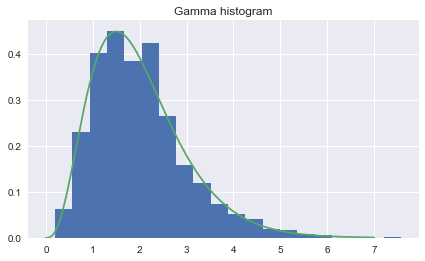

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
figure, axes = plt.subplots(1, 1, figsize=(7, 4))
axis1=axes
axis1.hist(gamma,bins=20, density=True)
x=np.linspace(0,7,500)
alpha = 4
beta = 2
axis1.plot(x,stats.gamma.pdf(x,a=alpha,scale=1/beta))
axis1.set_title(r'Gamma histogram')
plt.show()

In [7]:
file=open('inv_gamma.stan', 'r')
print(file.read())

data {
    real alpha;
    real beta;
}

generated quantities {
    real inv_gamma = inv_gamma_rng (alpha, beta);
}



In [8]:
model=stan_utility.compile_model('inv_gamma.stan')

Using cached StanModel


In [9]:
simulation_ppc=model.sampling(data=dict(alpha=2, beta=1),algorithm="Fixed_param", iter=1000, warmup=0, chains=1)
inv_gamma= simulation_ppc.extract()['inv_gamma']

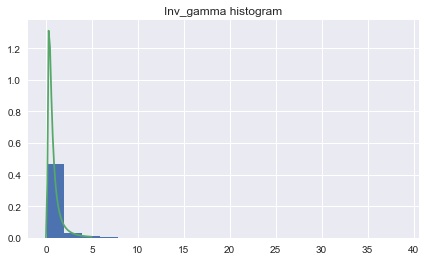

In [10]:
figure, axes = plt.subplots(1, 1, figsize=(7, 4))
axis1=axes
axis1.hist(inv_gamma,bins=20, density=True)
x=np.linspace(0,5,35)
alpha = 2
beta = 1
axis1.plot(x,stats.invgamma.pdf(x,a=alpha,scale=1/beta))
axis1.set_title(r'Inv_gamma histogram')
plt.show()

In [11]:
file=open('gamma_and_inv_gamma.stan', 'r')
print(file.read())

functions {
  vector gamma_solver(vector y, vector theta, real[] xr, int[] xi) {
    vector[3] output;
    
    output[1] = gamma_cdf(theta[1], y[1], y[2]) - y[3];
    output[2] = gamma_cdf(theta[2], y[1], y[2]) - (y[3] + 0.98);
    output[3] = y[1]/y[2] -8;
    
    return output;
  }
}

data {
  vector[2] theta;     
  vector[3] y_guess;
}

transformed data {
  vector[3] y;
  real xr[0];
  int xi[0];
  
  y = algebra_solver(gamma_solver, y_guess, theta, xr, xi);
}

generated quantities {
    real gamma = gamma_rng(y[1],y[2]);
    real inv_gamma = inv_gamma_rng(y[1],y[2]);
}


In [12]:
model_ppc=stan_utility.compile_model('gamma_new.stan')

Using cached StanModel


In [13]:
simulation=model_ppc.sampling(data=dict(theta=[5,10], y_guess=[6.7, 0.83, 0.09]),algorithm="Fixed_param",iter=1000,warmup=0,chains=1)
parameters=simulation.extract()

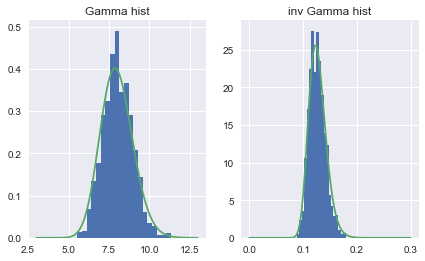

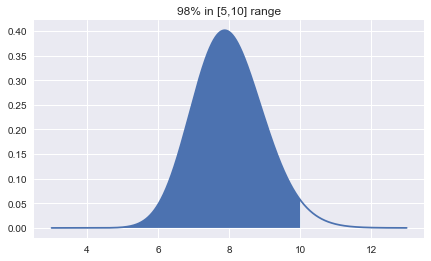

In [14]:
figure, axes = plt.subplots(1, 2, figsize=(7, 4))
axis1=axes[0]
axis1.hist(parameters['gamma'],bins=20,density=True)
x=np.linspace(3,13,500)
alpha = 64
beta = 8
axis1.plot(x,stats.gamma.pdf(x,a=alpha,scale=1/beta))
axis1.set_title(r'Gamma hist')


axis2=axes[1]
axis2.hist(parameters['inv_gamma'],bins=20,density=True)
x2=np.linspace(0,0.3,100)
axis2.plot(x2,stats.invgamma.pdf(x2,a=alpha,scale=beta))
axis2.set_title('inv Gamma hist')
plt.show()

figure, axis2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(3,13,1000)
x4=np.linspace(5,10,1000)
axis2.plot(x2,stats.gamma.pdf(x= x2,a= alpha,loc= 0,scale= 1/beta))
axis2.fill_between(x4,stats.gamma.pdf(x= x4,a= alpha,loc= 0,scale= 1/beta),0)
axis2.set_title(r'98% in [5,10] range')
plt.show()

In [1]:
#for parameters for Gamma and invGamma for which 98% probability is for values between 5 and 10 charts are more tight

In [15]:
#zadanie 2
file=open('neg_bin_con.stan', 'r')
print(file.read())  

data {
    real alpha;
    real mu;
}

generated quantities {
    real neg_bin_con = neg_binomial_rng (alpha, alpha/mu);
    real poisson_con = poisson_rng(neg_bin_con);
}



In [16]:
model_ppc=stan_utility.compile_model('neg_bin_con.stan')

Using cached StanModel


In [18]:
simulation=model_ppc.sampling(data=dict(alpha=2,mu=6),algorithm="Fixed_param", iter=500, warmup=0, chains=1)
parameters_simulation=simulation.extract()

In [19]:
neg_bin_pdf_eq = stats.nbinom(2, (2/6)/(2/6+1))
x=np.linspace(0, 100, 101)
neg_bin_pmf_con = []
for i in range(0, len(x)):
    neg_bin_pmf_con.append( neg_bin_pdf_eq.pmf( x[i] ))

C:\Users\Admin\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


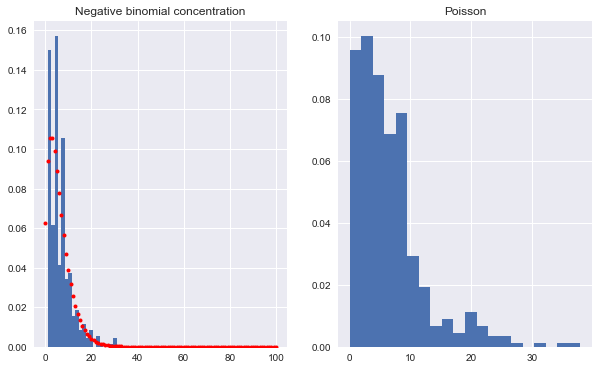

In [20]:
figure, axes = plt.subplots(1, 2, figsize=(10, 6))

axis1=axes[0]
axis1.hist(parameters_simulation['neg_bin_con'],bins=20, density=True)
axis1.plot(x, neg_bin_pmf_con,  'ro', markersize=4)
axis1.set_title(r'Negative binomial concentration')

axis2=axes[1]
axis2.hist(parameters_simulation['poisson_con'],density=True,bins=20)
axis2.set_title('Poisson')

plt.show()

In [21]:
file=open('neg_bin_disp.stan', 'r')
print(file.read())  

data {
    real mu;
    real phi;
}

generated quantities {
    real neg_bin_disp = neg_binomial_2_rng (mu, phi);
    real poisson_disp = poisson_rng(neg_bin_disp);
}



In [22]:
model_ppc=stan_utility.compile_model('neg_bin_disp.stan')

Using cached StanModel


In [23]:
simulation=model_ppc.sampling(data=dict(mu=6, phi=2),algorithm="Fixed_param", iter=500, warmup=0, chains=1)
parameters_simulation=simulation.extract()

In [24]:
neg_bin_pdf_eq = stats.nbinom(2, 2/(6+2))
x=np.linspace(0, 100, 101)
neg_bin_pmf_disp = []
for i in range(0, len(x)):
    neg_bin_pmf_disp.append( neg_bin_pdf_eq.pmf( x[i] ))

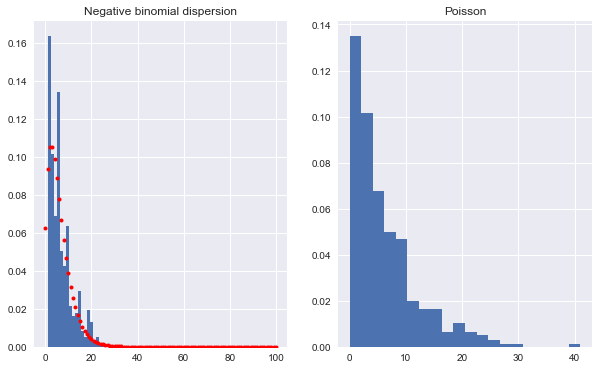

In [25]:
figure, axes = plt.subplots(1, 2, figsize=(10, 6))

axis1=axes[0]
axis1.hist(parameters_simulation['neg_bin_disp'],density=True,bins=20)
axis1.plot(x, neg_bin_pmf_disp,  'ro', markersize=4)
axis1.set_title('Negative binomial dispersion')

axis2=axes[1]
axis2.hist(parameters_simulation['poisson_disp'],density=True,bins=20)
axis2.set_title('Poisson')

plt.show()

In [2]:
#Negative binomial dispresion is more accurate than Poisson, it is divided into smaller parts

In [26]:
#zadanie 3
file=open('student_t_df.stan', 'r')
print(file.read())  

data {
  real df;
  real mu;
  real sigma;
}

generated quantities {
    real student_t = student_t_rng(df, mu,sigma);
}



In [27]:
model_ppc=stan_utility.compile_model('student_t_df.stan')

Using cached StanModel


In [28]:
R_dict=[10, 20, 50, 100,200,500,1000]
simulation_dict = []
y_dict = []
for i in range(0,len(R_dict)):
    simulation_dict.append(model_ppc.sampling(data=dict(df=2, mu=1,sigma=7),algorithm="Fixed_param",iter=R_dict[i],warmup=0,chains=1,))
    y_dict.append(simulation_dict[i].extract()['student_t'])

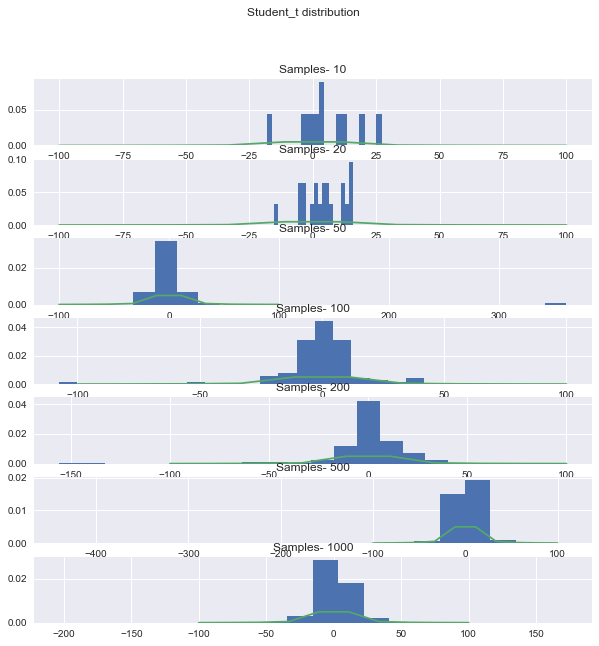

In [29]:
x=np.linspace(-100,100,10)
fig, axes = plt.subplots(len(R_dict), 1, figsize=(10, 10))
fig.suptitle('Student_t distribution')
for i in range(0,len(R_dict)):
    axis=axes[i]
    axis.hist(y_dict[i],bins=20,density=True)
    axis.plot(x,stats.t.pdf(x,df=1,loc=0,scale=2))
    axis.set_title(r'Samples- {}'.format(R_dict[i]))

plt.show()

In [30]:
for i in range(0,len(R_dict)):
    print("{} samples:".format(R_dict[i]))
    print("Mean = {}, variance = {}".format(np.mean(y_dict[i]), np.var(y_dict[i])))


10 samples:
Mean = 5.2558117428920825, variance = 148.5682058649634
20 samples:
Mean = 4.258089538129161, variance = 67.20053253589552
50 samples:
Mean = 6.037226197470168, variance = 2704.106488720483
100 samples:
Mean = -0.09698989202870445, variance = 274.7428467656489
200 samples:
Mean = -0.21808784630608927, variance = 478.33837297910793
500 samples:
Mean = 0.9149421074574678, variance = 619.9583291100435
1000 samples:
Mean = 0.783488393764205, variance = 298.921194602199


In [3]:
#for small amount of samples mean is smaller then for increased amunt of samplet. There isn't any dependence between amount of samples and variance.

In [31]:
# zadanie 4
file=open('multi_normal_2d.stan', 'r')
print(file.read())  

data {
  vector[2] mu;
  matrix[2,2] sigma;
}

generated quantities {
    vector[2] multi_normal = multi_normal_rng(mu,sigma);
}




In [32]:
model_ppc=stan_utility.compile_model('multi_normal_2d.stan')

Using cached StanModel


In [33]:
from statsmodels.stats.moment_helpers import cov2corr 

correlation= cov2corr([[2, 2], [2, 4]])
simulation=model_ppc.sampling(data=dict(mu=[3, 1],sigma=correlation),algorithm="Fixed_param",iter=1000,warmup=0,chains=1) 
parameters=simulation.extract()
multi_normal=parameters['multi_normal']
multi_normal1= [multi_normal[i][0] for i in range(0,1000)]
multi_normal2= [multi_normal[i][1] for i in range(0,1000)]

[]

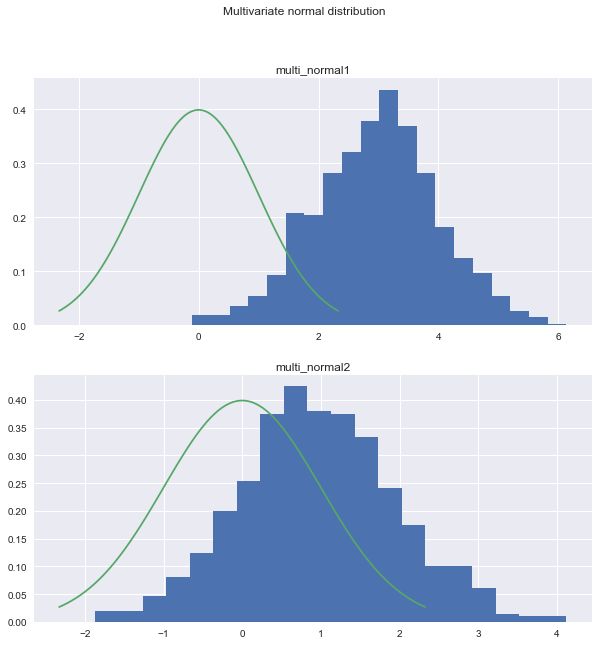

In [34]:
from scipy.stats import norm
x=np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)

figure, axes = plt.subplots(2, 1, figsize=(10, 10))
figure.suptitle('Multivariate normal distribution')
axis0=axes[0]
axis0.hist(multi_normal1,bins=20,density=True)
axis0.plot(x,norm.pdf(x))
axis0.set_title(r'multi_normal1')

axis1=axes[1]
axis1.hist(multi_normal2,bins=20,density=True)
axis1.plot(x,norm.pdf(x))
axis1.set_title(r'multi_normal2')

plt.plot()

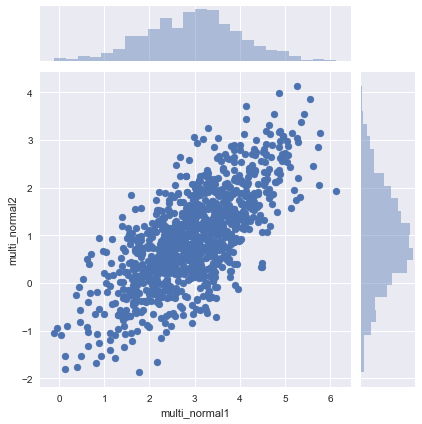

In [35]:
import seaborn as sns
df = pd.DataFrame(multi_normal, columns=["multi_normal1", "multi_normal2"])
sns.jointplot(x="multi_normal1", y="multi_normal2", data=df)

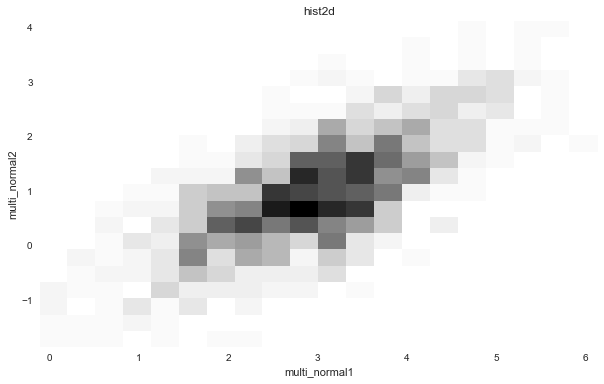

In [36]:
x=np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)

figure, axes = plt.subplots(1, 1, figsize=(10, 6))

axes.hist2d(multi_normal1,multi_normal2,bins=20, density=True)
axes.set_title(r'hist2d')
plt.xlabel('multi_normal1')
plt.ylabel('multi_normal2')

plt.show()

In [37]:
file=open('multi_normal_3d.stan', 'r')
print(file.read())

data {
  vector[3] mu;
  matrix[3,3] sigma;
}

generated quantities {
    vector[3] multi_normal = multi_normal_rng(mu,sigma);
}




In [38]:
model_ppc=stan_utility.compile_model('multi_normal_3d.stan')

Using cached StanModel


In [39]:
correlation= cov2corr([[6, 1, 4], [1, 6, 3],[4, 3, 7]])
simulation=model_ppc.sampling(data=dict(mu=[3, 3, 4],sigma=correlation),algorithm="Fixed_param",iter=1000,warmup=0,chains=1)
parameters=simulation.extract()
multi_normal=parameters['multi_normal']
multi_normal1= [multi_normal[i][0] for i in range(0,1000)]
multi_normal2= [multi_normal[i][1] for i in range(0,1000)]
multi_normal3= [multi_normal[i][2] for i in range(0,1000)]

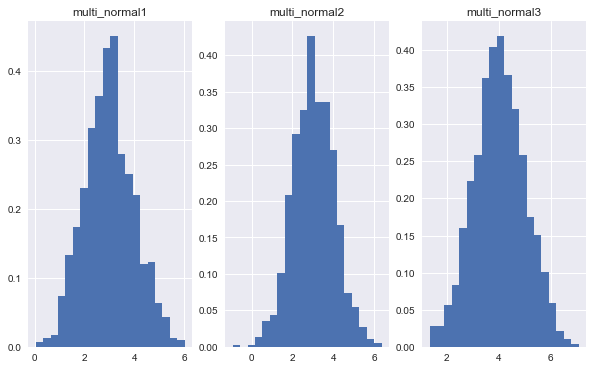

In [40]:
figure, axes = plt.subplots(1, 3, figsize=(10, 6))

axis1=axes[0]
axis1.hist(multi_normal1,bins=20,density=True)
axis1.set_title(r'multi_normal1')

axis2=axes[1]
axis2.hist(multi_normal2,bins=20,density=True)
axis2.set_title(r'multi_normal2')

axis2=axes[2]
axis2.hist(multi_normal3,bins=20,density=True)
axis2.set_title(r'multi_normal3')

plt.show()

In [41]:
file=open('multi_normal_4d.stan', 'r')
print(file.read())

data {
  vector[4] mu;
  matrix[4,4] sigma;
}

generated quantities {
    vector[4] multi_normal = multi_normal_rng(mu,sigma);
}




In [42]:
model_ppc=stan_utility.compile_model('multi_normal_4d.stan')

Using cached StanModel


In [43]:
correlation= cov2corr([[4, 2, 3, 2], [2, 5, 3, 4],[3, 3, 5, 1], [2, 4, 1, 8]])
simulation=model_ppc.sampling(data=dict(mu=[3, 3, 2, 1],sigma=correlation),algorithm="Fixed_param",iter=1000,warmup=0,chains=1)
parameters=simulation.extract()
multi_normal=parameters['multi_normal']
multi_normal1= [multi_normal[i][0] for i in range(0,1000)]
multi_normal2= [multi_normal[i][1] for i in range(0,1000)]
multi_normal3= [multi_normal[i][2] for i in range(0,1000)]
multi_normal4= [multi_normal[i][3] for i in range(0,1000)]

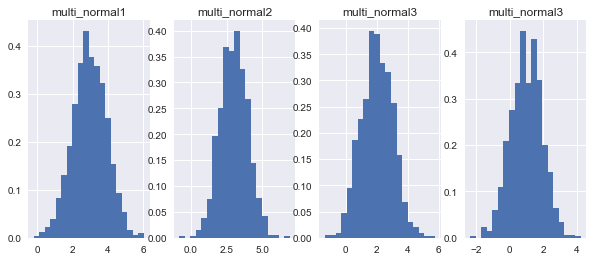

In [44]:
figure, axes = plt.subplots(1, 4, figsize=(10, 4))

axis1=axes[0]
axis1.hist(multi_normal1,bins=20,density=True)
axis1.set_title(r'multi_normal1')

axis2=axes[1]
axis2.hist(multi_normal2,bins=20,density=True)
axis2.set_title(r'multi_normal2')

axis3=axes[2]
axis3.hist(multi_normal3,bins=20,density=True)
axis3.set_title(r'multi_normal3')

axis4=axes[3]
axis4.hist(multi_normal4,bins=20,density=True)
axis4.set_title(r'multi_normal3')

plt.show()